# Thesis

- Topic: Plant Disease detection
- Author: Antriksh Kumar Singh
- Batch: October 21 (C11)

---

### Importing Libraries an initial checks

In [1]:
#  Installing required libraries
# !pip install numpy tensorflow pandas matplotlib opencv-python
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.0.0
asttokens                    2.0.5
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.1.0
certifi                      2022.5.18.1
cfgv                         3.3.1
charset-normalizer           2.0.12
colorama                     0.4.4
cycler                       0.11.0
debugpy                      1.6.0
decorator                    5.1.1
distlib                      0.3.4
entrypoints                  0.4
executing                    0.8.3
filelock                     3.4.2
flatbuffers                  1.12
fonttools                    4.33.3
gast                         0.4.0
google-auth                  2.6.6
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.46.3
h5py                         3.7.0
identify                     2.4.6
idna                         3.3
ipykern

In [2]:
# Importing all required libraries
import os
import pathlib as pl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# Check if GPU is recognized
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 741357198329507083
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10100539392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1876309769746721098
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


---

### Importing Data

In [5]:
# Defining base paths
CWD = os.getcwd()
DATA_PATH = "./data"
ABS_DATA_PATH = os.path.join(CWD,DATA_PATH)
plant_village = pl.Path(ABS_DATA_PATH)

In [6]:
# Initialization global vars
batch_size = 16
img_height = 256
img_width = 256
seed = 123
channels = 3

In [7]:
# Loading the plant village dataset
pv = tf.keras.utils.image_dataset_from_directory(
  plant_village,
  batch_size=batch_size,
  image_size=(img_height,img_width),
  shuffle=True,
  seed=seed
)

Found 55448 files belonging to 39 classes.


In [8]:
# Dataset summary
pv

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
# Plant Classes summary
all_classes = pv.class_names
all_images = list(plant_village.glob("*/*.jpg"))
all_classes_count = len(all_classes)
all_images_count = len(all_images)
print(f"Dataset have {all_classes_count} classes in total with {all_images_count} images\n")
print(all_classes)

Dataset have 39 classes in total with 55446 images

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Toma

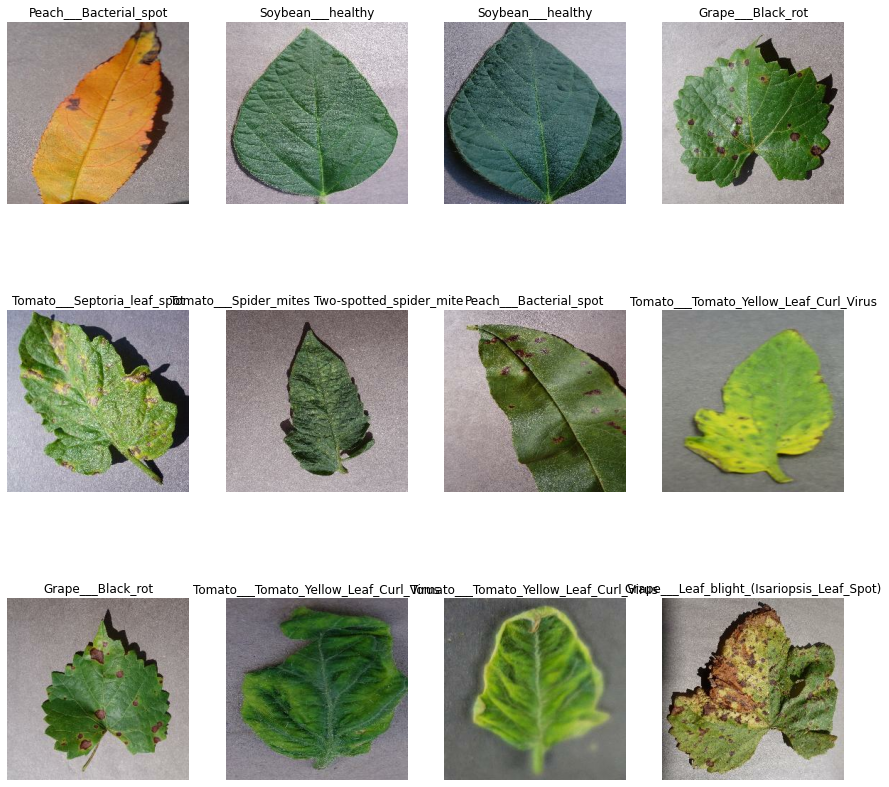

In [10]:
# Plotting random images the dataset batch
plt.figure(figsize = (15,15))
for image, label in pv.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1) # many plots at a time => subplots
        plt.imshow(image[i].numpy().astype('uint8')) #converting all data of image into numpy and than to integer type as they were in float.
        plt.title(all_classes[label[i]])  # title of the class_name of image
        plt.axis("off") # Hide the values of graph

---

### EDA

In [11]:
# Analyzing dataset
processed_labels = []
for _class in all_classes:
  if _class != "Background_without_leaves":
    l = _class.split('___')
    l.append(_class)
    processed_labels.append(l)

class_df = pd.DataFrame(processed_labels,columns=["plant","label","folder"])
class_df["abs_path"] = class_df["folder"].apply(lambda x: plant_village.joinpath(x))
class_df["images"] = class_df["abs_path"].apply(lambda x: len(os.listdir(x)))
class_df["is_healthy"] = class_df["label"]=="healthy"
class_df

,plant,label,folder,abs_path,images,is_healthy
0,Apple,Apple_scab,Apple___Apple_scab,d:\projects\masters\masters\Final Report\Code\...,630,False
1,Apple,Black_rot,Apple___Black_rot,d:\projects\masters\masters\Final Report\Code\...,621,False
2,Apple,Cedar_apple_rust,Apple___Cedar_apple_rust,d:\projects\masters\masters\Final Report\Code\...,275,False
3,Apple,healthy,Apple___healthy,d:\projects\masters\masters\Final Report\Code\...,1645,True
4,Blueberry,healthy,Blueberry___healthy,d:\projects\masters\masters\Final Report\Code\...,1502,True
5,Cherry,Powdery_mildew,Cherry___Powdery_mildew,d:\projects\masters\masters\Final Report\Code\...,1052,False
6,Cherry,healthy,Cherry___healthy,d:\projects\masters\masters\Final Report\Code\...,854,True
7,Corn,Cercospora_leaf_spot Gray_leaf_spot,Corn___Cercospora_leaf_spot Gray_leaf_spot,d:\projects\masters\masters\Final Report\Code\...,513,False
8,Corn,Common_rust,Corn___Common_rust,d:\projects\masters\masters\Final Report\Code\...,1192,False
9,Corn,Northern_Leaf_Blight,Corn___Northern_Leaf_Blight,d:\projects\masters\masters\Final Report\Code\...,985,False


In [12]:
# Total types of plants covered
all_plants = class_df["plant"].unique()
print(f"Plant village has images from {len(all_plants)} type of plants")

Plant village has images from 14 type of plants


In [13]:
# Summarizing dataset for binary classification at dataset level
health_summary = class_df.groupby('is_healthy').sum()
health_summary["ratio"]=health_summary["images"]/all_images_count
health_summary

,images,ratio
is_healthy,,
False,39221,0.707373
True,15084,0.272048


In [14]:
# Summarizing dataset for binary classification at plant level
pl_health_summary = class_df.groupby(['plant','is_healthy']).sum()
pl_health_summary

images
plant        is_healthy        
Apple        False         1526
             True          1645
Blueberry    True          1502
Cherry       False         1052
             True           854
Corn         False         2690
             True          1162
Grape        False         3639
             True           423
Orange       False         5507
Peach        False         2297
             True           360
Pepper,_bell False          997
             True          1478
Potato       False         2000
             True           152
Raspberry    True           371
Soybean      True          5090
Squash       False         1835
Strawberry   False         1109
             True           456
Tomato       False        16569
             True          1591

---

### Test Train Split

In [15]:
# Function for Splitting the data
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = seed)

  ds_size = len(ds)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, test_ds, val_ds

In [16]:
train_ds, test_ds, val_ds = split_dataset(pv)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)

---

### Image Preprocessing

In [18]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(img_height, img_width),
    layers.Rescaling(1.0/255)
])

In [19]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(factor = 0.5)
])

---

### Model Building

In [20]:
# Creating Convolution layer 
input_shape = (batch_size, img_height, img_width, channels)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),
])


model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                  

In [22]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size,
  verbose=1
)

Epoch 1/5
 283/2772 [==>...........................] - ETA: 1:53 - loss: nan - accuracy: 0.0126

KeyboardInterrupt: 